In [4]:
!nvidia-smi

Tue May 31 16:11:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
|  0%   25C    P8     3W / 260W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
|  0%   25C    P8     1W / 260W |   1136MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
import torch
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [6]:
#import for module
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import albumentations
import cv2
from glob import glob
from PIL import Image

#import for trainig
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

#import for own module
from datadiversity import *
from DiffAugment_pytorch import *
from consistencyimage import *
from cyclegan import *

In [12]:
class ImageDataset(Dataset):
    
    # input: image files
    # output: dataset class of transformed images
    
    def __init__(self, Name, transforms_ = None):
        self.transform = transforms_
        self.Name = Name
        self.domain_A_file = glob('./data_files/trainA/'+ Name)
        self.domain_B_file = glob('/mnt/disk2/thresh/thresh/magnesium_169/*.*')
        
    def __getitem__(self, index):
        domain_A = Image.open(self.domain_A_file[random.randint(0, len(self.domain_A_file) - 1)])
        domain_B = Image.open(self.domain_B_file[random.randint(0, len(self.domain_B_file) - 1)])
        
        if domain_A.mode == "RGB":
            domain_A = to_gray(domain_A)
        if domain_B.mode == "RGB":
            domain_B = to_gray(domain_B)
        
        domain_A = self.transform(domain_A)
        domain_B = self.transform(domain_B)
        
        return {"A": domain_A, "B": domain_B}
        
    def __len__(self):
        return max(len(self.domain_A_file), len(self.domain_B_file))
    
transforms_ = transforms.Compose([
    transforms.RandomCrop((256, 256)),
    transforms.RandomResizedCrop(size = 256, scale = (0.75, 1.), ratio = (0.75, 1.33)),
    transforms.ToTensor()
])

# build dataset class
train_dataset = ImageDataset(Name = "magnesium_169.jpg",transforms_ = transforms_)
val_dataset = ImageDataset(Name = "magnesium_169.jpg",transforms_ = transforms_)


# build dataloader class
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 0)

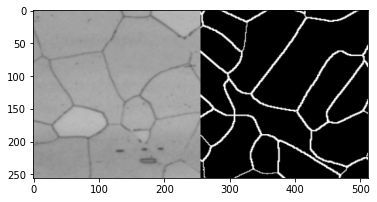

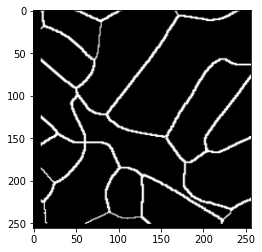

torch.Size([1, 1, 256, 256])

In [13]:
import time
start = time.time()
for batch in val_dataloader:
    real_A_ = batch["A"].cuda()
    real_B_ = batch["B"].cuda()
    real_A = make_grid(real_A_, nrow= 2, normalize=False)
    real_B = make_grid(real_B_, nrow = 2, normalize=False)
    img_grid = torch.cat((real_A,real_B),2)
    img_grid = img_grid.cpu()
    plt.imshow(img_grid.permute(1,2,0))
    plt.show()
    break
end = time.time()
#  translation
translation = DiffAugment(real_B_,"translation")
pil_image = tensor_to_pil(translation[0])
plt.imshow(pil_image,"gray")
plt.show()

check = random_rand_cutout(real_B_,min=8,max=32)
check.shape

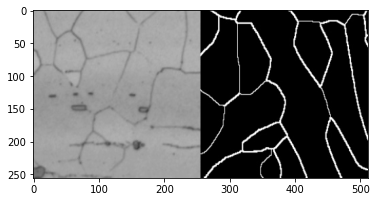

0.11622214317321777


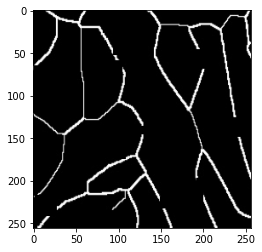

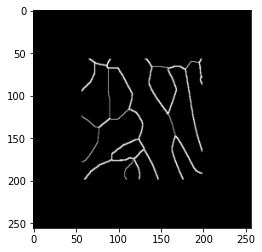

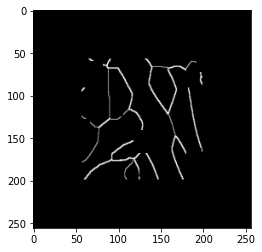

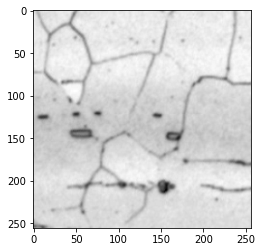

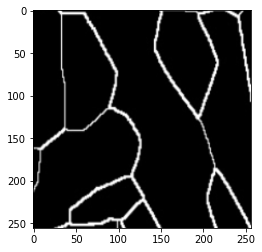

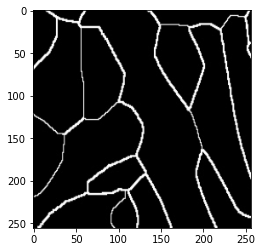

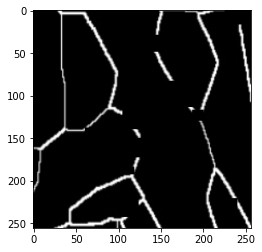

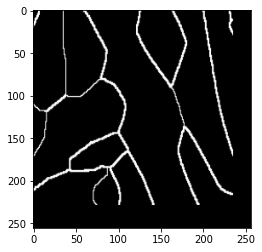

In [14]:
import time
start = time.time()
for batch in val_dataloader:
    real_A_ = batch["A"].cuda()
    real_B_ = batch["B"].cuda()
    real_A = make_grid(real_A_, nrow= 2, normalize=False)
    real_B = make_grid(real_B_, nrow = 2, normalize=False)
    img_grid = torch.cat((real_A,real_B),2)
    img_grid = img_grid.cpu()
    plt.imshow(img_grid.permute(1,2,0))
    plt.show()
    break
end = time.time()
print(end-start)
missing_B = random_rand_cutout(real_B_,min=8,max=32)
torch_image = random_rand_cutout(real_B_,min=8,max=32)
pil_image = tensor_to_pil(torch_image[0])
plt.imshow(pil_image,"gray")
plt.show()

# Zoom out
large = transforms_zoom_out(real_B_[0])
pil_image = tensor_to_pil(large[0])
plt.imshow(pil_image,"gray")
plt.show()

# Zoom out missing boundary image
large = torch.unsqueeze(large,0)
large = random_rand_cutout(large,min=32,max=40)
pil_image = tensor_to_pil(large[0])
plt.imshow(pil_image,"gray")
plt.show()

# Zoom in
small = transforms_zoom_in(real_A_[0])
pil_image = tensor_to_pil(small[0])
plt.imshow(pil_image,"gray")
plt.show()

# Zoom in
small = transforms_zoom_in(real_B_[0])
pil_image = tensor_to_pil(small[0])
plt.imshow(pil_image,"gray")
plt.show()

# Zoom in
pil_image = tensor_to_pil(real_B_[0])
plt.imshow(pil_image,"gray")
plt.show()

# Zoom in missing boundary image
small = torch.unsqueeze(small,0)
small = random_rand_cutout(small,min=8,max=32)
pil_image = tensor_to_pil(small[0])
plt.imshow(pil_image,"gray")
plt.show()

#  translation
translation = DiffAugment(real_B_,"translation")
pil_image = tensor_to_pil(translation[0])
plt.imshow(pil_image,"gray")
plt.show()

In [15]:
G_AB = GeneratorResNet(input_shape = (1, 256, 256), num_residual_blocks = 9)
G_BA = GeneratorResNet(input_shape = (1, 256, 256), num_residual_blocks = 9)
D_A = Discriminator(input_shape = (1, 256, 256))
D_B = Discriminator(input_shape = (1, 256, 256))


G_AB.cuda()
G_BA.cuda()
D_A.cuda()
D_B.cuda()

# weight initialization
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)


# define loss function
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
criterion_cr = torch.nn.MSELoss()

criterion_GAN.cuda()
criterion_cycle.cuda()
criterion_identity.cuda()
criterion_cr.cuda()

n_epoch = int(50)
decay_epoch = int(600)
lr = 0.0002


# define optimizer
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr = lr, betas = (0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr = lr, betas = (0.5, 0.999))


# learning rate scheduler
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda = LambdaLR(n_epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda = LambdaLR(n_epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda = LambdaLR(n_epoch, decay_epoch).step)

In [21]:
from pathlib import Path
Name = "original_DiffAug_GAN"
os.mkdir("/mnt/disk2/thresh/ckpt/" , exist_ok=True)
Path.mkdir("/mnt/disk2/thresh/result_files/" + Name, exist_ok = True )
Path.mkdir("/mnt/disk2/thresh/training_files" + Name, exist_ok = True)


AttributeError: 'str' object has no attribute '_closed'

[Epoch 1 / 1200] [D loss: 1.732524] [G identity loss: 0.025390, G adv loss: 0.629160, G cycle loss: 0.028447] [Elapsed time: 20.82s]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disk2/thresh/original/ckpt/G_AB_1.pt'

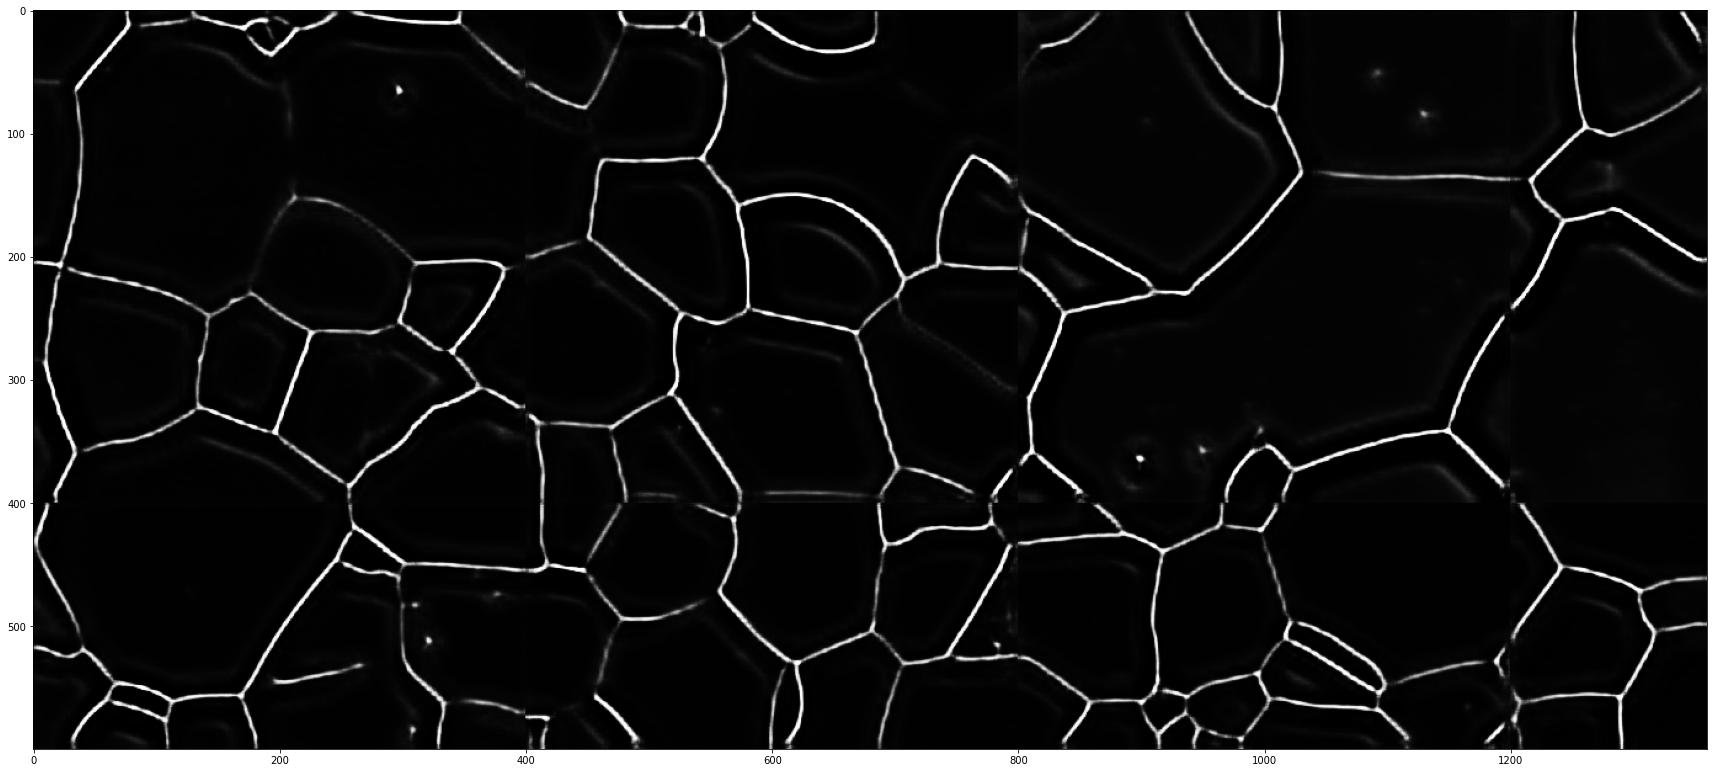

In [10]:
import time

# print option
n_prt = 50

# loss function weight
lambda_cycle = 10
lambda_identity = 5

# buffer
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()
test_image = np.array(to_gray(Image.open("./data_files/trainA/original.jpg")))
Name = "original_DiffAug_GAN"
D_loss = []
identity_loss = []
GAN_loss = []
cycle = []
inconsistency_loss = []
start_time = time.time()
n_epoch = 1200

for epoch in range(1, n_epoch):
    for i, batch in enumerate(train_dataloader):
        
        # load batch images
        real_A = batch['A'].cuda() # domain_A_real
        real_B = batch['B'].cuda() # domain_B_real
        
        # make label for discriminators
        real = torch.cuda.FloatTensor(real_A.shape[0], 1, 16, 16).fill_(1.0) # real_label
        fake = torch.cuda.FloatTensor(real_A.shape[0], 1, 16, 16).fill_(0.0) # fake_label
        
        
        ''' generator training '''
        # mode
        G_AB.train()
        G_BA.train()
        
        # zero gradient
        optimizer_G.zero_grad()
        
        # forward
        
        # Create diffaugmentation for real_image(True dataset)
        # real_A_diff = DiffAugment(real_A,policy = "translation,cutout")
        # real_B_diff = DiffAugment(real_B,policy = "translation,cutout")

        # loss
        
        loss_identity_A = criterion_identity(G_BA(real_A), real_A) # identity_loss_A
        loss_identity_B = criterion_identity(G_AB(real_B), real_B) # identity_loss_B
        loss_identity = (loss_identity_A + loss_identity_B) / 2 #identity_loss
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        
        missing_real_B = random_rand_cutout(real_B,min= 8,max= 32)
        missing_fake_B_ = random_rand_cutout(fake_B,min=8,max=32)
        
        #create fake image for diffaugmentation
        # fake_B_diff = G_AB(real_A_diff)
        # fake_B_diff = G_BA(real_B_diff)

        # Create diffaugmentation for fake_image(Fake dataset)
        # fake_A_diff = DiffAugment(fake_A,policy="translation,cutout")
        # fake_B_diff = DiffAugment(fake_B,policy="translation,cutout")
 
        # Create missing_boundary image
        # missing_real_B = torch.unsqueeze(transforms_missing_boundary(real_B.cpu()[0]), 0).cuda()
        # missing_fake_B = torch.unsqueeze(transforms_missing_boundary(fake_B.cpu()[0]),0).cuda()
        
        # adversarial_loss

        loss_GAN_AB = criterion_GAN(D_B(fake_B), real) # adversarial_loss_AB
        loss_GAN_BA = criterion_GAN(D_A(fake_A), real) # adversarial_loss_BA    
        loss_GAN_missing = criterion_GAN(D_A(missing_real_B), fake) + criterion_GAN(D_A(missing_fake_B_),fake) 
      
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2 + loss_GAN_missing
         
 
      
        # recover_A_diff = G_BA(fake_B_diff) # reconstruct_A
        # recover_B_diff = G_AB(fake_A_diff) # reconstruct_B
        recover_A = G_BA(fake_B)
        recover_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recover_A, real_A) # consistency_loss_A
        loss_cycle_B = criterion_cycle(recover_B, real_B) # consistency_loss_B
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2 # consistency_loss
           
        loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_identity * loss_identity # G_loss
        
        # update gradient
        loss_G.backward()
        optimizer_G.step()
        
        ''' discriminator A training '''
        
        # zero gradient
        optimizer_D_A.zero_grad()
        
        # loss
        loss_real = criterion_GAN(D_A(real_A), real)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        
        #Create missing boundary image for fake_A_
        # fake_A_diff_ = fake_A_diff_Buffer.push_and_pop(fake_A_diff)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        
        #Create zoom out and zoom in image for real_A
        zoom_out_real_A = torch.unsqueeze(transforms_zoom_out(real_A.cpu()[0]),0).cuda()
        zoom_in_real_A = torch.unsqueeze(transforms_zoom_in(real_A.cpu()[0]),0).cuda()
        
        #Create zoom out and zoom in image for fkae_A
        zoom_out_fake_A = torch.unsqueeze(transforms_zoom_out(fake_A_.detach().cpu()[0]),0).cuda()
        zoom_in_fake_A = torch.unsqueeze(transforms_zoom_in(fake_A_.detach().cpu()[0]),0).cuda()
        
        #loss consistency_regularization 
        # loss_cr = (criterion_cr(D_A(real_A), D_A(torch.unsqueeze(transforms_zoom_out(real_A.cpu()[0]), 0).cuda())) + \
        #            criterion_cr(D_A(real_A), D_A(torch.unsqueeze(transforms_zoom_in(real_A.cpu()[0]), 0).cuda()))) / 2
        loss_cr = criterion_cr(D_A(real_A), D_A(zoom_out_real_A)) + \
                  criterion_cr(D_A(real_A), D_A(zoom_in_real_A))
                  
                
        # loss_balanced_consistency_regularization
        # loss_bcr = (criterion_cr(D_A(fake_A_.detach()),D_A(torch.unsqueeze(transforms_zoom_out(fake_A_.detach().cpu()[0]),0).cuda())) + \
        #             criterion_cr(D_A(fake_A_.detach()),D_A(torch.unsqueeze(transforms_zoom_in(fake_A_.detach().cpu()[0]),0).cuda())))/2
        
        loss_bcr = criterion_cr(D_A(fake_A_.detach()),D_A(zoom_out_fake_A)) + \
                   criterion_cr(D_A(fake_A_.detach()),D_A(zoom_in_fake_A))
        
        #loss for discriminator 
        loss_D_A = (loss_real + loss_fake) / 2 + loss_cr +loss_bcr
        
        # update gradient
        loss_D_A.backward()
        optimizer_D_A.step()
        
        ''' discriminator B training '''
        # zero gradient
        optimizer_D_B.zero_grad()
        
        # loss
        loss_real = criterion_GAN(D_B(real_B), real)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        # fake_B_diff = fake_B_diff_Buffer.push_and_pop(fake_B_diff)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        
        #Create missing boundary images for real image and missing_fake_B
        missing_real_B = random_rand_cutout(real_B,min= 8,max= 32)
        missing_fake_B = random_rand_cutout(fake_B_.detach(),min=8,max=32)
       
        #Create zoom out and zoom in images for real_B
        zoom_out_real_B = torch.unsqueeze(transforms_zoom_out(real_B.cpu()[0]),0).cuda()
        zoom_in_real_B = torch.unsqueeze(transforms_zoom_in(real_B.cpu()[0]),0).cuda()
        
        #Create missing boundary images of zoom out and zoom in images for real_B
        missing_zoom_out_real_B = random_rand_cutout(zoom_out_real_B,min=32,max=40)
        missing_zoom_in_real_B = random_rand_cutout(zoom_in_real_B,min=8,max=32)
        
        #Create zoom out and zoom in images for fake_B
        zoom_out_fake_B = torch.unsqueeze(transforms_zoom_out(fake_B_.detach().cpu()[0]),0).cuda()
        zoom_in_fake_B = torch.unsqueeze(transforms_zoom_in(fake_B_.detach().cpu()[0]),0).cuda()
        
        #Create missing boundary images of zoom out and zoom in images for  fake_B_
        missing_zoom_out_fake_B = random_rand_cutout(zoom_out_fake_B,min=32,max=40)
        missing_zoom_in_fake_B = random_rand_cutout(zoom_in_fake_B,min=8,max=32)
                
        # loss consistency_regularization
        # loss_cr = (criterion_cr(D_B(real_B), D_B(torch.unsqueeze(transforms_zoom_out(real_B.cpu()[0]), 0).cuda())) + \
        #            criterion_cr(D_B(real_B), D_B(torch.unsqueeze(transforms_zoom_in(real_B.cpu()[0]), 0).cuda())))/2
        
        loss_cr = criterion_cr(D_B(real_B),D_B(zoom_out_real_B))+ \
                  criterion_cr(D_B(real_B),D_B(zoom_in_real_B))
                
        # loss inconsistency_regularization 
        # # /1-D(real_B)-D(missing_real_B)/ + /1-D(zoom_out_real_B)-D(missing_zoom_out_real_B)/ + /1-D(zoom_in_real_B)-D(missing_zoom_in_real_B)/
        # loss_icr = criterion_cr(1-D_B(real_B),D_B(missing_real_B)) +criterion_cr(1-D_B(zoom_out_real_B),D_B(missing_zoom_out_real_B)) + criterion_cr(1-D_B(zoom_in_real_B),D_B(missing_zoom_in_real_B))
        loss_icr = criterion_cr(D_B(missing_real_B),fake) + \
                   criterion_cr(D_B(missing_zoom_in_real_B),fake) + \
                   criterion_cr(D_B(missing_zoom_out_real_B),fake)
        #loss_balanced_consistency_regularization
        # loss_bcr = (criterion_cr(D_B(fake_B_.detach()),D_B(torch.unsqueeze(transforms_zoom_out(fake_B_.detach().cpu()[0]),0).cuda())) + \
        #             criterion_cr(D_B(fake_B_.detach()),D_B(torch.unsqueeze(transforms_zoom_in(fake_B_.detach().cpu()[0]),0).cuda())))/2      
        
        loss_bcr = criterion_cr(D_B(fake_B_.detach()),D_B(zoom_out_fake_B)) + \
                   criterion_cr(D_B(fake_B_.detach()),D_B(zoom_in_fake_B))
                                          
        #loss_balanced_inconsistency_regularization
        # loss_ibcr = criterion_cr(1-D_B(fake_B_.detach()),D_B(missing_fake_B)) + \
        #             criterion_cr(1-D_B(zoom_out_fake_B),D_B(missing_zoom_out_fake_B)) +\
        #             criterion_cr(1-D_B(zoom_in_fake_B),D_B(missing_zoom_in_fake_B))
        
        loss_ibcr = criterion_cr(D_B(missing_fake_B),fake) + \
                    criterion_cr(D_B(missing_zoom_out_fake_B),fake) + \
                    criterion_cr(D_B(missing_zoom_in_fake_B),fake) 
                                 
        loss_D_B = (loss_real + loss_fake) / 2 + loss_cr + loss_icr + loss_bcr + loss_ibcr
        
        # update gradient
        loss_D_B.backward()
        optimizer_D_B.step()
        
        ''' print '''
        loss_D = (loss_D_A + loss_D_B) / 2
        done = (epoch - 1) * len(train_dataloader) + i
        
    
            
    print(f"[Epoch {epoch} / {n_epoch}] [D loss: {loss_D.item():.6f}] [G identity loss: {loss_identity.item():.6f}, G adv loss: {loss_GAN.item():.6f}, G cycle loss: {loss_cycle.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")
    if epoch % 1 == 0:
       D_loss.append(loss_D.item())
       identity_loss.append(loss_identity.item())
       GAN_loss.append(loss_GAN.item())
       cycle.append(loss_cycle.item())
       if 'original' in Name:
          space_x = int(test_image.shape[0]/400)+1
          space_y = int(test_image.shape[1]/400)+1
          img_list_x = []     
       for j in range(space_x):
         img_list_y = []
         for k in range(space_y):
           img = test_image[400*j:400*(j+1),400*k:400*(k+1)]
           img = transforms.ToTensor()(img)
           img = img.unsqueeze(0)
           img = img.cuda()
           fake_B = G_AB(img).squeeze(0).squeeze(0).cpu().data.numpy()
           img_list_y.append(fake_B)
         boundary_image = np.concatenate(img_list_y,axis = 1)
         img_list_x.append(boundary_image)  
       image_recover = np.concatenate(img_list_x,axis=0)
       imgae_recover = Image.fromarray(image_recover)
       plt.figure(figsize=(30,30))
       plt.imshow(image_recover,"gray")
       plt.savefig(f"/mnt/disk2/thresh/result_files/original/{epoch}.jpg")
      #  plt.show()  

    if epoch % 150 == 0:
        G_AB.eval()
        G_BA.eval()
        fake_B_ = G_AB(real_A_)
        fake_A_ = G_BA(real_B_)
        fake_A_missing = G_BA(missing_B)
        
        real_A = make_grid(real_A_, nrow = 5, normalize = False)
        real_B = make_grid(real_B_, nrow = 5, normalize = False)
        fake_A = make_grid(fake_A_, nrow = 5, normalize = False)
        fake_B = make_grid(fake_B_, nrow = 5, normalize = False)
        fake_missing = make_grid(fake_A_missing,nrow = 5, normalize = False)
        image_grid = torch.cat((real_A, fake_B, real_B, fake_A,fake_missing), 2)
        image_grid = image_grid.cpu()
        save_image(image_grid, f"/mnt/disk2/thresh/training_files/original/{epoch}.png", normalize = False)

    torch.save(G_AB.state_dict(), f"/mnt/disk2/thresh/ckpt/original/G_AB_{int(epoch)}.pt")
    torch.save(G_BA.state_dict(), f"/mnt/disk2/thresh/ckpt/original/G_BA_{int(epoch)}.pt")
    torch.save(D_A.state_dict(), f"/mnt/disk2/thresh/ckpt/original/D_A_{int(epoch)}.pt")
    torch.save(D_B.state_dict(), f"/mnt/disk2/thresh/ckpt/original/D_B_{int(epoch)}.pt")
    print("Model saved!")
    
    # learning rate
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()